In [4]:
import numpy
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
import pyLDAvis.gensim_models
from gensim.models import LdaModel
from gensim.corpora import Dictionary
pyLDAvis.enable_notebook()

from utils import RESOURCE_PATH, RESULT_PATH, get_sentences

In [5]:
def lda_vis(lemma_pos):
    dct = Dictionary.load(f"{RESOURCE_PATH}/dictionaries/dct_stats.dat")
    lda_model = LdaModel.load(f"{RESOURCE_PATH}/models/lda/{lemma_pos}.dat")

    sentences = get_sentences(lemma_pos)
    corpus = [dct.doc2bow(doc) for doc in sentences]

    lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dct)
    pyLDAvis.display(lda_display)

In [24]:
def corr_vis(model_type, mode, ontology):
    with open(f"{RESOURCE_PATH}/stats/adj.txt", "r", encoding="utf-8") as adj, open(f"{RESOURCE_PATH}/stats/adv.txt", "r", encoding="utf-8") as adv, open(f"{RESOURCE_PATH}/stats/noun.txt", "r", encoding="utf-8") as noun,\
            open(f"{RESOURCE_PATH}/stats/verb.txt", "r", encoding="utf-8") as ver, open(f"{RESULT_PATH}/{model_type}/td_{mode}.txt", "r", encoding="utf-8") as lemma_topic:
        pos_file = {
            "ADJ": adj,
            "ADV": adv,
            "NOUN": noun,
            "VER": ver,
        }

        lemma_pos_topic = {} # "lemma_pos": n_topic

        dct = Dictionary.load(f"{RESOURCE_PATH}/dictionaries/dct_stats.dat")

        for line in lemma_topic:
            line = line.strip()
            lemma_pos, n_topic, _ = line.strip().split("\t")

            if lemma_pos in dct.values():
                lemma_pos_topic[lemma_pos] = float(n_topic)

        n_topics_wordnet_tot = []
        n_topics_wiktionary_tot = []
        n_senses_wordnet_tot = []
        n_senses_wiktionary_tot = []

        result = {}

        for pos, file in pos_file.items():
            lemma_senses = {} # "lemma_pos": (n_senses_wordnet, n_senses_wiktionary)

            for line in file:
                lemma, wordnet_senses, wiktionary_senses, _, _ = line.split("\t")
                lemma = f"{lemma}_{pos}"
                wordnet_senses = int(wordnet_senses)
                wiktionary_senses = int(wiktionary_senses)

                lemma_senses[lemma] = (wordnet_senses, wiktionary_senses)
            
            n_topics_wordnet = []
            n_topics_wiktionary = []
            n_senses_wordnet = []
            n_senses_wiktionary = []
            
            for lemma_pos, (n_wordnet, n_wiktionary) in lemma_senses.items():
                if lemma_pos in lemma_pos_topic:
                    n_topic = lemma_pos_topic[lemma_pos]

                    if n_wordnet != -1:
                        n_topics_wordnet.append(n_topic)
                        n_senses_wordnet.append(n_wordnet)

                    if n_wiktionary != -1:
                        n_topics_wiktionary.append(n_topic)
                        n_senses_wiktionary.append(n_wiktionary)

            if ontology == "wordnet":
                n_senses = n_senses_wordnet
                n_topics = n_topics_wordnet
            elif ontology == "wiktionary":
                n_senses = n_senses_wiktionary
                n_topics = n_topics_wiktionary

            #print(int(max(n_topics_wordnet)))
            plt.plot(n_senses, n_topics, ".")
            xticks(range(int(max(n_senses))+1))
            #yticks(range(int(max(n_senses_wiktionary))+1))
            plt.title(f"{model_type} - {ontology} - {mode} - {pos}")
            plt.xlabel("n_senses")
            plt.ylabel("n_topics")
            plt.show()

            coeff_wordnet = spearmanr(numpy.array(n_topics_wordnet), numpy.array(n_senses_wordnet))
            coeff_wiktionary = spearmanr(n_topics_wiktionary, n_senses_wiktionary)

            n_topics_wordnet_tot.extend(n_topics_wordnet)
            n_topics_wiktionary_tot.extend(n_topics_wiktionary)
            n_senses_wordnet_tot.extend(n_senses_wordnet)
            n_senses_wiktionary_tot.extend(n_senses_wiktionary)

            result[pos] = (coeff_wordnet, coeff_wiktionary)

        if ontology == "wordnet":
            n_senses_tot = n_senses_wordnet_tot
            n_topics_tot = n_topics_wordnet_tot
        elif ontology == "wiktionary":
            n_senses_tot = n_senses_wiktionary_tot
            n_topics_tot = n_topics_wiktionary_tot

        plt.plot(n_senses_tot, n_topics_tot, ".")
        xticks(range(int(max(n_senses_tot))+1))
        #yticks(range(int(max(n_senses_wiktionary))+1))
        plt.title(f"{model_type} - {ontology} - {mode} - TOT")
        plt.xlabel("n_senses_wordnet")
        plt.ylabel("n_topics_wordnet")
        plt.show()

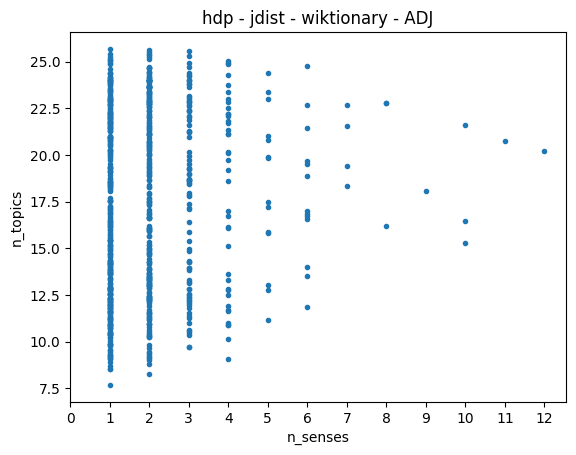

SpearmanrResult(correlation=0.055958465508600556, pvalue=0.10487774817555032)


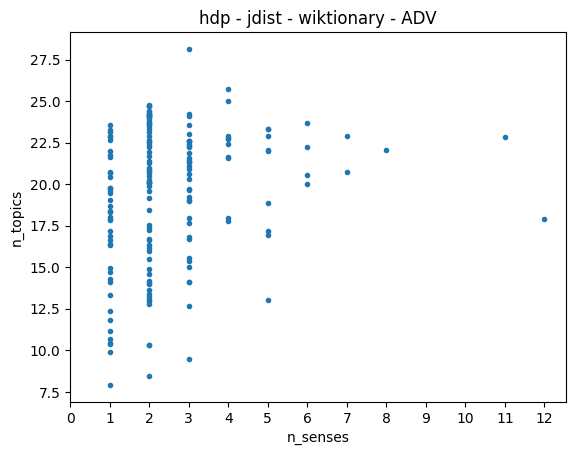

SpearmanrResult(correlation=-0.08557536028866858, pvalue=0.2587844930900005)


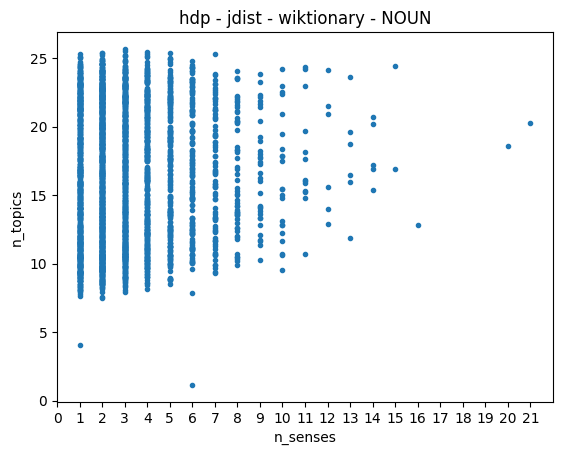

SpearmanrResult(correlation=0.1105751674242423, pvalue=5.407223521684272e-10)


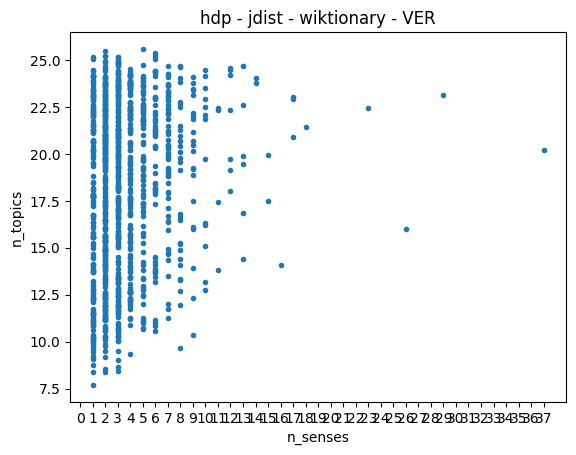

SpearmanrResult(correlation=0.052926858299285326, pvalue=0.07316565528991088)


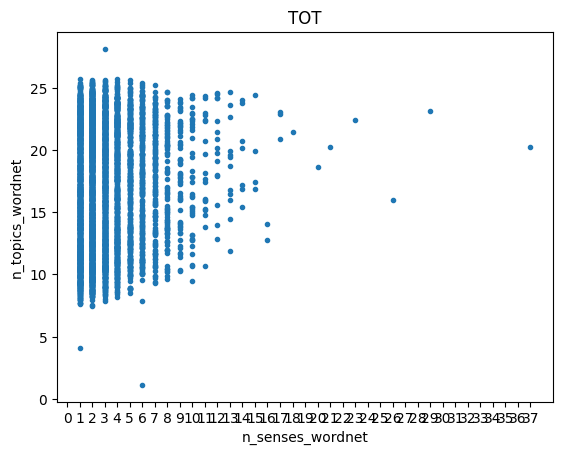

In [25]:
corr_vis("hdp", "jdist", "wiktionary")